In [47]:
# === SuspiciousLinkRadar: Ortam Hazırlık / Başlangıç Hücresi ===
# Bu hücre: bağımlılık kontrolü, opsiyonel eksik paket kurulumu, temel sürüm bilgisi ve seed ayarı.
# Notebook'u paylaşırken dışarıya yalnızca bu hücre + requirements.txt referansı yeterli olur.

# Ayarlar
AUTO_INSTALL = False          # Eksik paketleri otomatik kurmak için True yap
SHOW_PACKAGE_VERSIONS = True  # Paket sürümlerini raporla
SEED = 42

import sys
import os
import platform
import importlib
import subprocess
import time
import warnings
import json

# Bilimsel + Görselleştirme
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
np.random.seed(SEED)

REQUIRED_PKGS = [
    "tldextract",
    "fastapi",
    "scikit-learn",
    "seaborn",
    "matplotlib",
    "joblib",
    "regex",
    "orjson",
]

def detect_missing(packages):
    missing = []
    for p in packages:
        if importlib.util.find_spec(p) is None:
            missing.append(p)
    return missing

missing = detect_missing(REQUIRED_PKGS)
print(f"Eksik paketler: {missing if missing else 'YOK'}")

if missing and AUTO_INSTALL:
    print("Eksik paketlerin kurulumu başlıyor...")
    # Notebook ortamında doğru environment'a kurmak için %pip kullanımı (IPython) tercih edilebilir:
    # Fakat programatik kurulum için subprocess kullanılabilir.
    for pkg in missing:
        print(f"-> pip install {pkg}")
        subprocess.run([sys.executable, "-m", "pip", "install", pkg], check=True)
    # Kurulum sonrası tekrar kontrol
    post_missing = detect_missing(REQUIRED_PKGS)
    print(f"Kurulum sonrası eksik: {post_missing if post_missing else 'YOK'}")
    if post_missing:
        print("Bazı paketler kurulamadı; elle kontrol gerekebilir.")
    else:
        # tldextract ilk kullanımda PSL indirir; hız için bir kez ön ısıtma yapıyoruz.
        import tldextract  # noqa
        _t0 = time.time()
        _ = tldextract.extract("https://example.com")
        print(f"tldextract PSL cache hazır (%.2fs)" % (time.time() - _t0))

# Sürüm bilgisi (opsiyonel)
print("\n=== Ortam Bilgisi ===")
print("Python:", sys.version.split()[0])
print("OS:", platform.platform())
print("Working Dir:", os.path.abspath("."))
print("Seed:", SEED)

if SHOW_PACKAGE_VERSIONS:
    def safe_version(mod_name):
        try:
            mod = importlib.import_module(mod_name)
            return getattr(mod, "__version__", "no __version__ attr")
        except Exception:
            return "NOT IMPORTABLE"
    versions = {p: safe_version(p) for p in REQUIRED_PKGS}
    print("Paket Sürümleri:", json.dumps(versions, indent=2, ensure_ascii=False))

# Proje paketleri (internal)
try:
    from slr.utils.url import normalize_url
    from slr.features.extractor import extract
    from slr.features.config import FEATURE_NAMES, to_vector, LABEL_MAP as IDX2LABEL, FEATURE_VERSION
    print("\nSLR paket modülleri başarıyla yüklendi.")
except ModuleNotFoundError as e:
    print(f"SLR paket import hatası: {e}.")
    print("Çözüm: Proje kökü doğru mu? VS Code kernel 'SLR' sanal ortamı mı kullanıyor?")
    raise

# Küçük yardımcılar
def set_global_seed(seed: int = 42):
    np.random.seed(seed)

def time_block(label, func, *args, **kwargs):
    t0 = time.time()
    out = func(*args, **kwargs)
    print(f"[TIME] {label}: {time.time() - t0:.2f}s")
    return out

print("\nHazırlık tamam. Bir sonraki hücrede veri yükleme + EDA yapabilirsiniz.")

Eksik paketler: ['scikit-learn']

=== Ortam Bilgisi ===
Python: 3.10.18
OS: Windows-10-10.0.22631-SP0
Working Dir: c:\Users\LENOVO\Desktop\Aktif Projeler\SuspiciousLinkRadar
Seed: 42
Paket Sürümleri: {
  "tldextract": "5.1.2",
  "fastapi": "0.121.2",
  "scikit-learn": "NOT IMPORTABLE",
  "seaborn": "0.13.2",
  "matplotlib": "3.10.5",
  "joblib": "1.5.1",
  "regex": "2.5.159",
  "orjson": "3.11.4"
}

SLR paket modülleri başarıyla yüklendi.

Hazırlık tamam. Bir sonraki hücrede veri yükleme + EDA yapabilirsiniz.


In [48]:
ROOT = os.path.abspath(".")
DATA_RAW_PATH = os.path.join(ROOT, "data", "raw", "malicious_phish.csv")
FALLBACK_PATH = os.path.join(ROOT, "malicious_phish.csv")
PROCESSED_DIR = os.path.join(ROOT, "data", "processed")
MODELS_DIR = os.path.join(ROOT, "models")

os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

CSV_PATH = DATA_RAW_PATH if os.path.exists(DATA_RAW_PATH) else FALLBACK_PATH
assert os.path.exists(CSV_PATH), f"Veri bulunamadı: {CSV_PATH}"
CSV_PATH

'c:\\Users\\LENOVO\\Desktop\\Aktif Projeler\\SuspiciousLinkRadar\\data\\raw\\malicious_phish.csv'

In [49]:
df = pd.read_csv(CSV_PATH)
print(df.head(3))
print(df.columns.tolist())

# Beklenen kolonlar: 'url', 'type'  (type ∈ {benign, defacement, phishing, malware})
assert "url" in df.columns and "type" in df.columns

df["type"] = df["type"].astype(str).str.lower()
print("Sınıf dağılımı:")
print(df["type"].value_counts(normalize=True).rename("ratio"))

                                   url      type
0                     br-icloud.com.br  phishing
1  mp3raid.com/music/krizz_kaliko.html    benign
2      bopsecrets.org/rexroth/cr/1.htm    benign
['url', 'type']
Sınıf dağılımı:
type
benign        0.657415
defacement    0.148124
phishing      0.144521
malware       0.049939
Name: ratio, dtype: float64


In [50]:
from urllib.parse import urlsplit
import tldextract

def etld_plus_one(u: str) -> str:
    try:
        netloc = urlsplit(u).netloc
        ext = tldextract.extract(netloc)
        return ext.registered_domain or netloc or "unknown"
    except Exception:
        return "unknown"

type_to_idx = {"benign": 0, "defacement": 1, "phishing": 2, "malware": 3}

df["url_norm"] = df["url"].astype(str).map(normalize_url)
df["group"] = df["url_norm"].map(etld_plus_one).astype(str)
df["label"] = df["type"].map(type_to_idx)
df = df.dropna(subset=["url_norm", "label"])
df = df.drop_duplicates(subset=["url_norm"]).reset_index(drop=True)

print("Kayıt sayısı (normalize+dedup sonra):", len(df))
print(df[["url", "url_norm", "type", "group"]].head(3))

Kayıt sayısı (normalize+dedup sonra): 640361
                                   url  \
0                     br-icloud.com.br   
1  mp3raid.com/music/krizz_kaliko.html   
2      bopsecrets.org/rexroth/cr/1.htm   

                                      url_norm      type    group  
0                     http:///br-icloud.com.br  phishing  unknown  
1  http:///mp3raid.com/music/krizz_kaliko.html    benign  unknown  
2      http:///bopsecrets.org/rexroth/cr/1.htm    benign  unknown  


In [51]:
from sklearn.model_selection import StratifiedGroupKFold

y = df["label"].values
g = df["group"].values

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(sgkf.split(df, y, g))
df_train_temp = df.iloc[train_idx].reset_index(drop=True)
df_test = df.iloc[test_idx].reset_index(drop=True)

y2 = df_train_temp["label"].values
g2 = df_train_temp["group"].values
sgkf2 = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
tr_idx, val_idx = next(sgkf2.split(df_train_temp, y2, g2))
df_train = df_train_temp.iloc[tr_idx].reset_index(drop=True)
df_val = df_train_temp.iloc[val_idx].reset_index(drop=True)

for name, d in [("train", df_train), ("val", df_val), ("test", df_test)]:
    print(name, ":", len(d), "→ class dist")
    print(d["label"].value_counts(normalize=True).sort_index().rename("ratio"))

train : 611995 → class dist
label
0    0.690908
1    0.130058
2    0.145856
3    0.033178
Name: ratio, dtype: float64
val : 12350 → class dist
label
0    0.156356
1    0.586154
2    0.158947
3    0.098543
Name: ratio, dtype: float64
test : 16016 → class dist
label
0    0.202360
1    0.528909
2    0.142483
3    0.126249
Name: ratio, dtype: float64


In [52]:
def df_to_matrix(d: pd.DataFrame):
    feats_list = [extract(u) for u in d["url_norm"].tolist()]
    X = np.array([to_vector(f) for f in feats_list], dtype=float)
    y = d["label"].astype(int).values
    groups = d["group"].astype(str).values
    return X, y, groups

t0 = time.time()
X_tr, y_tr, g_tr = df_to_matrix(df_train)
X_va, y_va, g_va = df_to_matrix(df_val)
X_te, y_te, g_te = df_to_matrix(df_test)
print("Vektörleştirme süresi: %.2fs" % (time.time() - t0))

X_tr.shape, X_va.shape, X_te.shape

Vektörleştirme süresi: 60.38s


((611995, 40), (12350, 40), (16016, 40))

In [53]:
# === Dayanıklı Model Eğitim Hücresi (Logistic Regression) ===

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import f1_score, classification_report
import importlib
import sys, traceback
import pandas as pd  # summary_df için

def check_numpy_integrity():
    issues = []
    try:
        import numpy
        core_mods = ["numpy.core.numeric", "numpy.core.multiarray", "numpy.core.umath"]
        for m in core_mods:
            if importlib.util.find_spec(m) is None:
                issues.append(f"Modül bulunamadı: {m}")
        if importlib.util.find_spec("numpy._core.numeric") is not None:
            issues.append("Beklenmeyen modül: numpy._core.numeric (kurulum anomalisi)")
        return issues
    except Exception as e:
        return [f"Numpy import genel hata: {e}"]

integrity_issues = check_numpy_integrity()
if integrity_issues:
    print("UYARI: NumPy bütünlük sorunları tespit edildi:")
    for i in integrity_issues:
        print(" -", i)
    print("Öneri: Kernel restart + force reinstall (numpy, scikit-learn, joblib).")

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        multi_class="auto",
        solver="lbfgs",
        random_state=42,
    )),
])

param_grid = {"clf__C": [0.1, 1.0, 3.0, 10.0]}
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

def run_gridsearch(parallel=True):
    n_jobs = -1 if parallel else 1
    print(f"GridSearch başlatılıyor (parallel={parallel}, n_jobs={n_jobs})")
    gs = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=cv,
        n_jobs=n_jobs,
        verbose=1,
        error_score="raise",
    )
    gs.fit(X_tr, y_tr, groups=g_tr)
    return gs

def manual_search():
    print("Paralel yapı hatası sonrası manuel (tek iş parçacıklı) tarama başlıyor.")
    best_score = -1
    best_params = None
    best_model = None
    for C in param_grid["clf__C"]:
        local_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                C=C,
                max_iter=3000,
                class_weight="balanced",
                multi_class="auto",
                solver="lbfgs",
                random_state=42,
            )),
        ])
        fold_scores = []
        for fold_id, (tr_idx, va_idx) in enumerate(cv.split(X_tr, y_tr, groups=g_tr), start=1):
            X_fold_tr, y_fold_tr = X_tr[tr_idx], y_tr[tr_idx]
            X_fold_va, y_fold_va = X_tr[va_idx], y_tr[va_idx]
            local_pipe.fit(X_fold_tr, y_fold_tr)
            preds = local_pipe.predict(X_fold_va)
            f1m = f1_score(y_fold_va, preds, average="macro")
            fold_scores.append(f1m)
        avg_score = float(np.mean(fold_scores))
        print(f"C={C} → fold_scores={np.round(fold_scores,4)} avg={avg_score:.4f}")
        if avg_score > best_score:
            best_score = avg_score
            best_params = {"clf__C": C}
            best_model = local_pipe
    return best_model, best_params, best_score

try:
    gs = run_gridsearch(parallel=True)
    best = gs.best_estimator_
    best_params = gs.best_params_
    cv_score = gs.best_score_
    print("GridSearch tamamlandı. En iyi:", best_params, "CV f1_macro=%.4f" % cv_score)
except Exception:
    print("Paralel GridSearch hata verdi:")
    traceback.print_exc(limit=3)
    print("\n→ Fallback stratejisi: n_jobs=1 ile tekrar deneme.")
    try:
        gs = run_gridsearch(parallel=False)
        best = gs.best_estimator_
        best_params = gs.best_params_
        cv_score = gs.best_score_
        print("Tek iş parçacıklı GridSearch tamamlandı. En iyi:", best_params, "CV f1_macro=%.4f" % cv_score)
    except Exception:
        print("Tek iş parçacıklı GridSearch da hata verdi. Manuel taramaya geçiliyor...")
        best, best_params, cv_score = manual_search()
        print("Manuel tarama sonucu en iyi:", best_params, "CV f1_macro=%.4f" % cv_score)

val_pred = best.predict(X_va)
test_pred = best.predict(X_te)
val_f1 = f1_score(y_va, val_pred, average="macro")
test_f1 = f1_score(y_te, test_pred, average="macro")
print("\nVal macro-F1:", round(val_f1, 4))
print("Test macro-F1:", round(test_f1, 4))

idx_order = sorted(IDX2LABEL.keys())
target_names = [IDX2LABEL[i] for i in idx_order]

val_report = classification_report(y_va, val_pred, target_names=target_names, output_dict=True)
test_report = classification_report(y_te, test_pred, target_names=target_names, output_dict=True)

summary_df = pd.DataFrame({
    "metric": ["cv_f1_macro","val_f1_macro","test_f1_macro"],
    "value": [cv_score, val_f1, test_f1],
    "algo": ["logreg"]*3,
    "best_C": [best_params.get("clf__C")]*3
})
summary_df

GridSearch başlatılıyor (parallel=True, n_jobs=-1)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
GridSearch tamamlandı. En iyi: {'clf__C': 10.0} CV f1_macro=0.6526

Val macro-F1: 0.711
Test macro-F1: 0.6506


,metric,value,algo,best_C
0,cv_f1_macro,0.652558,logreg,10.0
1,val_f1_macro,0.711011,logreg,10.0
2,test_f1_macro,0.650587,logreg,10.0


In [54]:
val_pred = best.predict(X_va)
test_pred = best.predict(X_te)

val_f1 = f1_score(y_va, val_pred, average="macro")
test_f1 = f1_score(y_te, test_pred, average="macro")
print("Val macro-F1:", round(val_f1, 4))
print("Test macro-F1:", round(test_f1, 4))

idx_order = sorted(IDX2LABEL.keys())
target_names = [IDX2LABEL[i] for i in idx_order]

val_report = classification_report(y_va, val_pred, target_names=target_names, output_dict=True)
test_report = classification_report(y_te, test_pred, target_names=target_names, output_dict=True)

pd.DataFrame(val_report).T.round(3).head(10)

Val macro-F1: 0.711
Test macro-F1: 0.6506


,precision,recall,f1-score,support
benign,0.869,0.545,0.670,1931.0
defacement,0.843,0.946,0.892,7239.0
phishing,0.741,0.496,0.594,1963.0
malware,0.590,0.826,0.688,1217.0
accuracy,0.800,0.800,0.800,0.8
macro avg,0.761,0.703,0.711,12350.0
weighted avg,0.806,0.800,0.790,12350.0


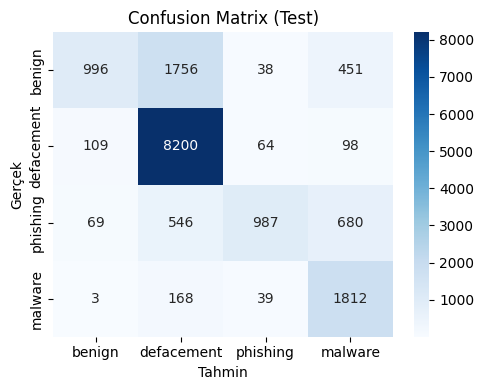

In [55]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, test_pred, labels=idx_order)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Tahmin"); plt.ylabel("Gerçek"); plt.title("Confusion Matrix (Test)")
plt.tight_layout(); plt.show()

ECE (phishing, val): 0.0255


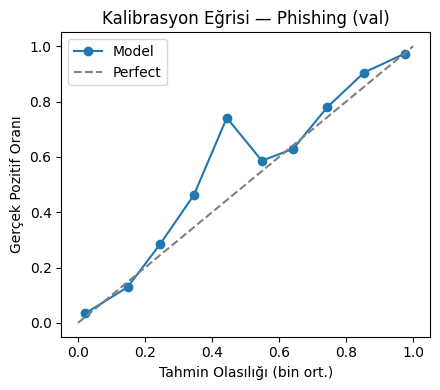

In [56]:
from sklearn.calibration import calibration_curve

def select_class_probas(model, X, class_idx: int):
    # predict_proba çok sınıflı: NxK
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, class_idx]
    # decision_function → yumuşak normalizasyon
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        if s.ndim == 1:
            s = np.vstack([-s, s]).T
        exps = np.exp(s - s.max(axis=1, keepdims=True))
        return (exps / exps.sum(axis=1, keepdims=True))[:, class_idx]
    # fallback
    preds = model.predict(X)
    return (preds == class_idx).astype(float)

def expected_calibration_error(y_true, probas, n_bins=10, positive_class=None):
    # y_true çok sınıflı → ikiliye indir (pozitif sınıf = class_idx)
    y_bin = (y_true == positive_class).astype(int)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        mask = (probas > bins[i]) & (probas <= bins[i+1])
        if not np.any(mask):
            continue
        conf = probas[mask].mean()
        acc = y_bin[mask].mean()
        ece += (mask.mean()) * abs(acc - conf)
    return float(ece)

PHISH_IDX = 2  # phishing
probs_va = select_class_probas(best, X_va, PHISH_IDX)
frac_pos, mean_pred = calibration_curve((y_va==PHISH_IDX).astype(int), probs_va, n_bins=10)

ece = expected_calibration_error(y_va, probs_va, n_bins=10, positive_class=PHISH_IDX)
print("ECE (phishing, val):", round(ece, 4))

plt.figure(figsize=(4.5,4))
plt.plot(mean_pred, frac_pos, "o-", label="Model")
plt.plot([0,1],[0,1],"--", color="gray", label="Perfect")
plt.xlabel("Tahmin Olasılığı (bin ort.)"); plt.ylabel("Gerçek Pozitif Oranı")
plt.title("Kalibrasyon Eğrisi — Phishing (val)")
plt.legend(); plt.tight_layout(); plt.show()

Phishing F1 max: 0.6895 → threshold≈ 0.274


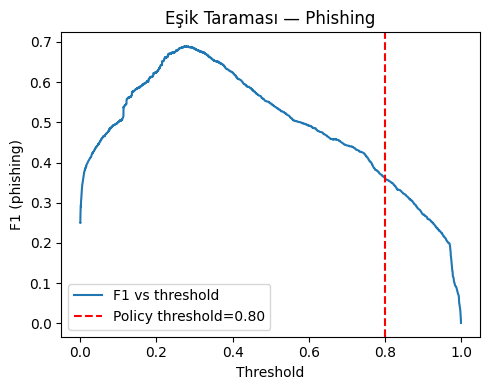

In [57]:
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(
    (y_te == PHISH_IDX).astype(int),
    select_class_probas(best, X_te, PHISH_IDX)
)
f1s = 2 * (prec * rec) / np.maximum(prec + rec, 1e-9)
ix = np.nanargmax(f1s)
print("Phishing F1 max:", round(f1s[ix], 4), "→ threshold≈", round(thr[max(ix-1, 0)], 3))

plt.figure(figsize=(5,4))
plt.plot(thr, f1s[:-1], label="F1 vs threshold")
plt.axvline(0.80, color="red", linestyle="--", label="Policy threshold=0.80")
plt.xlabel("Threshold"); plt.ylabel("F1 (phishing)")
plt.title("Eşik Taraması — Phishing")
plt.legend(); plt.tight_layout(); plt.show()

In [58]:
import joblib
metrics = {
    "algo": "lr",
    "feature_version": FEATURE_VERSION,
    "best_params": best_params,
    "val_f1_macro": float(val_f1),
    "test_f1_macro": float(test_f1),
    "val_report": val_report,
    "test_report": test_report,
}

with open(os.path.join(MODELS_DIR, "metrics_v1.0.json"), "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# Artefakt: model + özellik isimleri + label map
artifact = {
    "model": best,
    "feature_names": FEATURE_NAMES,
    "feature_version": FEATURE_VERSION,
    "label_map": IDX2LABEL,
}
joblib.dump(artifact, os.path.join(MODELS_DIR, "model_v1.0.pkl"))

with open(os.path.join(MODELS_DIR, "label_map_v1.0.json"), "w", encoding="utf-8") as f:
    json.dump(IDX2LABEL, f, indent=2, ensure_ascii=False)

with open(os.path.join(MODELS_DIR, "feature_config_v1.0.json"), "w", encoding="utf-8") as f:
    json.dump({"feature_version": FEATURE_VERSION, "feature_names": FEATURE_NAMES}, f, indent=2, ensure_ascii=False)

print("Artefaktlar kaydedildi →", MODELS_DIR)

Artefaktlar kaydedildi → c:\Users\LENOVO\Desktop\Aktif Projeler\SuspiciousLinkRadar\models


In [59]:
# === Split Yazımı (Dayanıklı) ===
import csv, json, os

keep_cols = ["url", "url_norm", "label", "group"]

# Etiket dtype güvence
for dname, dframe in [("train", df_train), ("val", df_val), ("test", df_test)]:
    if dframe["label"].isna().sum() > 0:
        raise ValueError(f"{dname} setinde beklenmeyen NaN label var.")
    df_train["label"] = df_train["label"].astype(int)
    df_val["label"] = df_val["label"].astype(int)
    df_test["label"] = df_test["label"].astype(int)

csv_kwargs = dict(
    index=False,
    quoting=csv.QUOTE_MINIMAL,
    escapechar="\\",
    lineterminator="\n",
)

# Yaz
df_train[keep_cols].to_csv(os.path.join(PROCESSED_DIR, "train.csv"), **csv_kwargs)
df_val[keep_cols].to_csv(os.path.join(PROCESSED_DIR, "val.csv"), **csv_kwargs)
df_test[keep_cols].to_csv(os.path.join(PROCESSED_DIR, "test.csv"), **csv_kwargs)

with open(os.path.join(PROCESSED_DIR, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump({
        "counts": {"train": len(df_train), "val": len(df_val), "test": len(df_test)},
        "feature_version": FEATURE_VERSION,
        "label_map": IDX2LABEL
    }, f, indent=2, ensure_ascii=False)

print("Processed splits yazıldı →", PROCESSED_DIR)

Processed splits yazıldı → c:\Users\LENOVO\Desktop\Aktif Projeler\SuspiciousLinkRadar\data\processed


In [60]:
from slr.models.infer import load_artifact, predict_url

artifact = load_artifact(os.path.join(MODELS_DIR, "model_v1.0.pkl"))

samples = [
    "https://example.com/",
    "http://secure-update-account.free-gift.click/verify/login",
    "https://192.168.1.50/bank/confirm?session=abcd",
    "http://paypa1.com-login.verify.info/update",
]
for s in samples:
    out = predict_url(artifact, s, threshold=0.80)
    print(s, "→", out["label"], "| p=", round(out["probability"], 3), "| risk=", out["risk_level"])

https://example.com/ → malware | p= 0.692 | risk= caution
http://secure-update-account.free-gift.click/verify/login → phishing | p= 1.0 | risk= danger
https://192.168.1.50/bank/confirm?session=abcd → phishing | p= 0.848 | risk= danger
http://paypa1.com-login.verify.info/update → phishing | p= 1.0 | risk= danger


In [61]:
# === API Test Hücresi (Otomatik Port Bulucu) ===
import requests
import os

# Denenecek portlar listesi
CANDIDATE_PORTS = [8081, 8090, 8080]
API_PORT = None
BASE = None

print("API aranıyor...")

# Çalışan portu bul
for p in CANDIDATE_PORTS:
    try:
        # Health check atıyoruz (timeout kısa tutuldu)
        r = requests.get(f"http://127.0.0.1:{p}/health", timeout=1)
        if r.status_code == 200:
            API_PORT = p
            print(f"✅ API bulundu: Port {API_PORT}")
            break
    except requests.exceptions.ConnectionError:
        continue

if API_PORT is None:
    print("❌ API hiçbir portta (8081, 8090, 8080) bulunamadı.")
    print("Çözüm: Terminalden 'python -m uvicorn app.main:app --port 8081' komutunu çalıştırın.")
else:
    API_BASE = f"http://127.0.0.1:{API_PORT}"
    try:
        # Tahmin isteği gönder
        resp = requests.post(
            f"{API_BASE}/predict",
            json={"url": "http://secure-login.paypal-update.com", "threshold": 0.80},
            timeout=3
        )
        print("\nİstek Sonucu:")
        print("Status Code:", resp.status_code)
        print("Response:", resp.json())
    except Exception as e:
        print("Tahmin isteği sırasında hata oluştu:", e)

API aranıyor...
✅ API bulundu: Port 8081

İstek Sonucu:
Status Code: 200
Response: {'label': 'phishing', 'probability': 0.977354, 'risk_level': 'danger'}
